Wealth bin range: [ 58.0 , 260.0 ]
Number of wealth bins: 102


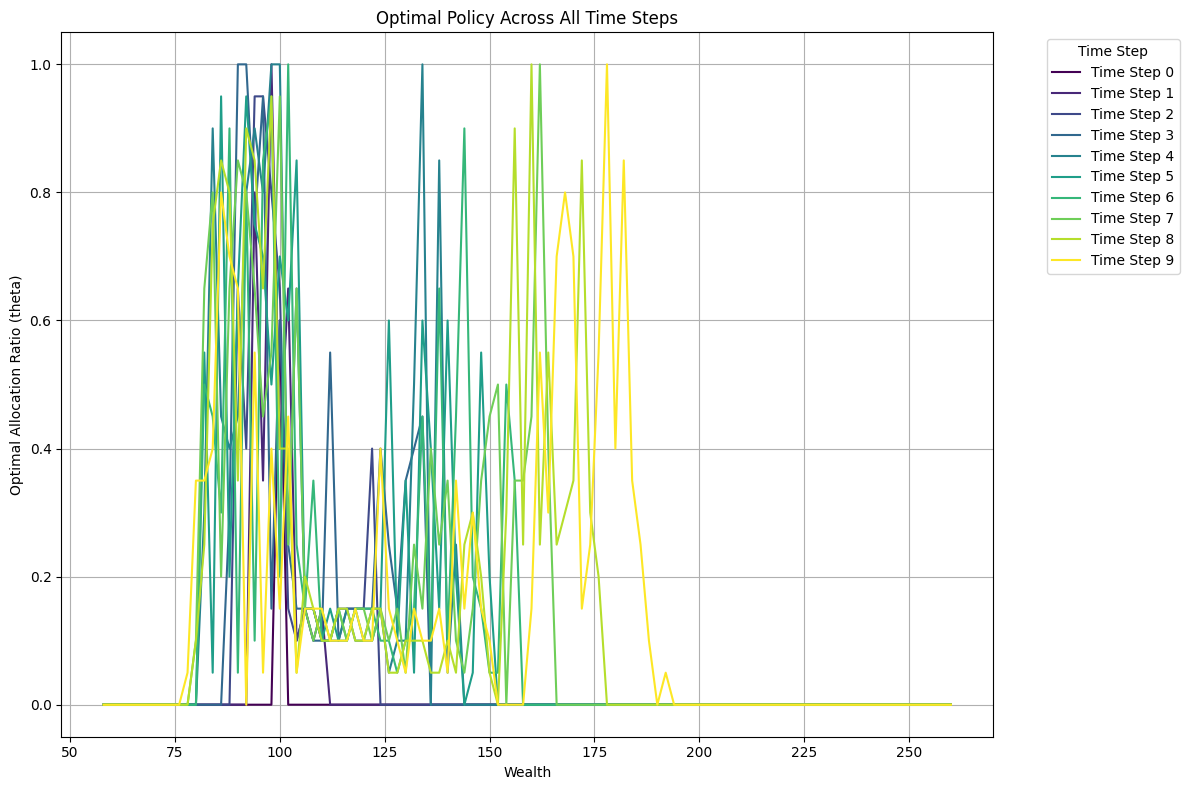

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parameter settings
T = 10  # Total time steps
W0 = 100  # Initial wealth
a = 0.1  # High return of risky asset
b = -0.05  # Low return of risky asset
p = 0.6  # Probability of high return
r = 0.02  # Risk-free asset return
gamma = 0.9  # Discount factor
alpha = 0.1  # Learning rate
epsilon = 0.1  # Exploration probability (epsilon-greedy)
num_episodes = 100000  # Number of training episodes

# Calculate maximum and minimum possible wealth
W_max = W0 * (1 + a) ** T  # Max wealth: always choose high return
W_min = W0 * (1 + b) ** T  # Min wealth: always choose low return
W_risk_free = W0 * (1 + r) ** T  # Wealth with risk-free asset only
W_min = min(W_min, W_risk_free)  # Adjust min wealth to include risk-free case
W_max = max(W_max, W_risk_free)  # Adjust max wealth to include risk-free case

# Discretize wealth into bins with interval of 2
W_min_rounded = np.floor(W_min / 2) * 2  # Round down W_min to nearest multiple of 2
W_max_rounded = np.ceil(W_max / 2) * 2   # Round up W_max to nearest multiple of 2
wealth_values = np.arange(W_min_rounded, W_max_rounded + 2, 2)  # Wealth bins with step size 2
wealth_bins = len(wealth_values)  # Number of wealth bins
theta_bins = np.linspace(0, 1, 21)  # Discretize allocation ratio (theta) into 21 bins from 0 to 1

# Initialize Q-table with zeros
# Dimensions: (wealth bins, time steps, theta bins)
Q = np.zeros((wealth_bins, T, len(theta_bins)))

# Function to map wealth to the nearest bin value
def map_to_wealth_bin(W):
    """
    Map a continuous wealth value to the nearest bin value.
    
    Args:
        W (float): Continuous wealth value
    
    Returns:
        int: Index of the nearest wealth bin
        float: Corresponding bin value
    """
    idx = np.argmin(np.abs(wealth_values - W))  # Find index of closest bin
    return idx, wealth_values[idx]

# Environment simulation function
def step(W, t, theta):
    """
    Simulate one step in the environment.
    
    Args:
        W (float): Current wealth (bin value)
        t (int): Current time step
        theta (float): Proportion of wealth allocated to risky asset
    
    Returns:
        W_next (float): Next period's wealth (mapped to bin value)
        reward (float): Reward, defined as wealth increment
    """
    # Determine risky asset return (high or low) based on probability p
    risk_return = a if np.random.rand() < p else b
    # Calculate next wealth: theta in risky asset, (1-theta) in risk-free asset
    W_next_continuous = W * (theta * (1 + risk_return) + (1 - theta) * (1 + r))
    # Map to nearest wealth bin
    _, W_next = map_to_wealth_bin(W_next_continuous)
    # Reward is the change in wealth
    reward = W_next - W
    return W_next, reward

# TD Learning loop
for episode in range(num_episodes):
    W = W0  # Reset wealth to initial value for each episode
    _, W = map_to_wealth_bin(W)  # Map initial wealth to nearest bin
    for t in range(T):
        # Discretize current wealth to an index
        W_idx, _ = map_to_wealth_bin(W)
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            theta_idx = np.random.choice(len(theta_bins))  # Random exploration
        else:
            theta_idx = np.argmax(Q[W_idx, t])  # Exploit best action based on Q-value
        theta = theta_bins[theta_idx]  # Map index to actual theta value
        
        # Take a step in the environment
        W_next, reward = step(W, t, theta)
        W_next_idx, _ = map_to_wealth_bin(W_next)  # Discretize next wealth
        
        # Compute TD target and update Q-value
        if t == T - 1:  # t=T-1
            reward = -np.exp(-a * W_next) / a
            Q_target = reward
        else:
            reward = 0
            Q_target = reward + gamma * np.max(Q[W_next_idx, t + 1])  # Include discounted future reward
        
        # if t == T - 1:
        #     Q_target = reward  # No future reward at final time step
        # else:
        #     Q_target = reward + gamma * np.max(Q[W_next_idx, t + 1])  # Include discounted future reward
        
        # Update Q-value using TD learning rule
        Q[W_idx, t, theta_idx] += alpha * (Q_target - Q[W_idx, t, theta_idx])
        
        # Transition to next state
        W = W_next

# Compute optimal policy
optimal_policy = np.zeros((wealth_bins, T))
for W_idx in range(wealth_bins):
    for t in range(T):
        optimal_policy[W_idx, t] = theta_bins[np.argmax(Q[W_idx, t])]

# Print wealth range and optimal policy
print("Wealth bin range: [", W_min_rounded, ",", W_max_rounded, "]")
print("Number of wealth bins:", wealth_bins)
# print("Wealth bin values:", wealth_values)
# print("Optimal policy (wealth bins x time steps):")
# print(optimal_policy)

# Function to plot optimal policy for all time steps on the same figure
def plot_optimal_policy_all():
    """
    Plot the optimal allocation ratio (theta) for different wealth levels across all time steps
    on a single figure with different colors for each time step.
    """
    # Create the plot
    plt.figure(figsize=(12, 8))
    
    # Define a color map for different time steps
    colors = plt.cm.viridis(np.linspace(0, 1, T))
    
    # Plot optimal policy for each time step
    for t in range(T):
        theta_optimal = optimal_policy[:, t]
        plt.plot(wealth_values, theta_optimal, label=f"Time Step {t}", color=colors[t])
    
    # Add labels, title, grid, and legend
    plt.xlabel("Wealth")
    plt.ylabel("Optimal Allocation Ratio (theta)")
    plt.title("Optimal Policy Across All Time Steps")
    plt.grid(True)
    plt.legend(title="Time Step", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()  # Adjust layout to prevent overlap with legend
    plt.show()

# Plot optimal policy for all time steps
plot_optimal_policy_all()

Running benchmark with gamma = 0.9


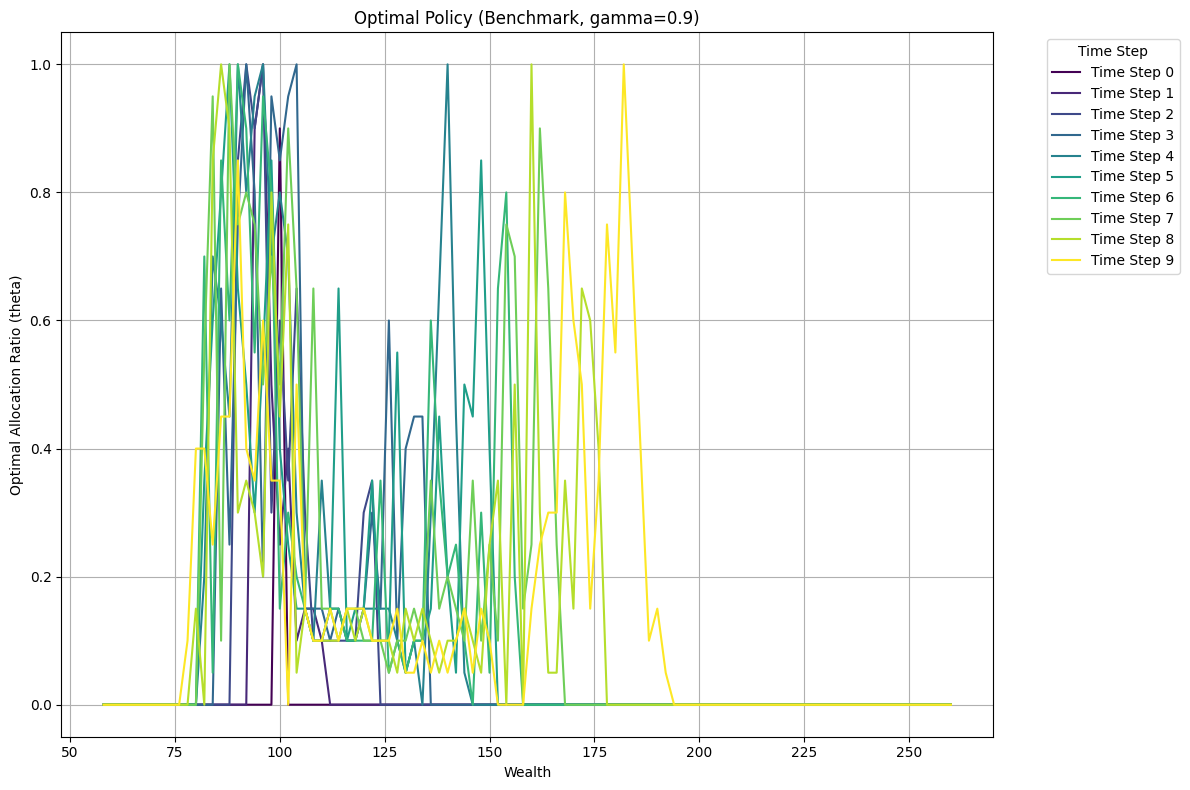

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def run_portfolio_optimization(a, b, p, gamma, alpha, num_episodes, epsilon, wealth_bin_interval, T=10, W0=100, r=0.02):
    """
    Run portfolio optimization using TD learning with specified parameters.
    
    Args:
        a (float): High return of risky asset
        b (float): Low return of risky asset
        p (float): Probability of high return
        gamma (float): Discount factor
        alpha (float): Learning rate
        num_episodes (int): Number of training episodes
        epsilon (float): Exploration probability (epsilon-greedy)
        wealth_bin_interval (float): Interval size for wealth bins
        T (int): Total time steps (default: 10)
        W0 (int): Initial wealth (default: 100)
        r (float): Risk-free asset return (default: 0.02)
    
    Returns:
        wealth_values (np.ndarray): Array of wealth bin values
        optimal_policy (np.ndarray): Optimal policy array (wealth bins x time steps)
    """
    # Calculate maximum and minimum possible wealth
    W_max = W0 * (1 + a) ** T  # Max wealth: always choose high return
    W_min = W0 * (1 + b) ** T  # Min wealth: always choose low return
    W_risk_free = W0 * (1 + r) ** T  # Wealth with risk-free asset only
    W_min = min(W_min, W_risk_free)
    W_max = max(W_max, W_risk_free)

    # Discretize wealth into bins with specified interval
    W_min_rounded = np.floor(W_min / wealth_bin_interval) * wealth_bin_interval
    W_max_rounded = np.ceil(W_max / wealth_bin_interval) * wealth_bin_interval
    wealth_values = np.arange(W_min_rounded, W_max_rounded + wealth_bin_interval, wealth_bin_interval)
    wealth_bins = len(wealth_values)
    theta_bins = np.linspace(0, 1, 21)  # Discretize theta into 21 bins

    # Initialize Q-table
    Q = np.zeros((wealth_bins, T, len(theta_bins)))

    # Function to map wealth to nearest bin
    def map_to_wealth_bin(W):
        idx = np.argmin(np.abs(wealth_values - W))
        return idx, wealth_values[idx]

    # Environment step function
    def step(W, t, theta):
        risk_return = a if np.random.rand() < p else b
        W_next_continuous = W * (theta * (1 + risk_return) + (1 - theta) * (1 + r))
        _, W_next = map_to_wealth_bin(W_next_continuous)
        reward = W_next - W
        return W_next, reward

    # TD Learning loop
    for episode in range(num_episodes):
        W = W0
        _, W = map_to_wealth_bin(W)  # Map initial wealth
        for t in range(T):
            W_idx, _ = map_to_wealth_bin(W)
            if np.random.rand() < epsilon:
                theta_idx = np.random.choice(len(theta_bins))  # Explore
            else:
                theta_idx = np.argmax(Q[W_idx, t])  # Exploit
            theta = theta_bins[theta_idx]
            
            W_next, reward = step(W, t, theta)
            W_next_idx, _ = map_to_wealth_bin(W_next)
            
            if t == T - 1:  # t=T-1
                reward = -np.exp(-a * W_next) / a
                Q_target = reward
            else:
                reward = 0
                Q_target = reward + gamma * np.max(Q[W_next_idx, t + 1])  # Include discounted future reward
                
            # if t == T - 1:
            #     Q_target = reward
            # else:
            #     Q_target = reward + gamma * np.max(Q[W_next_idx, t + 1])
            
            Q[W_idx, t, theta_idx] += alpha * (Q_target - Q[W_idx, t, theta_idx])
            W = W_next

    # Compute optimal policy
    optimal_policy = np.zeros((wealth_bins, T))
    for W_idx in range(wealth_bins):
        for t in range(T):
            optimal_policy[W_idx, t] = theta_bins[np.argmax(Q[W_idx, t])]

    return wealth_values, optimal_policy

def plot_optimal_policy_all(wealth_values, optimal_policy, title="Optimal Policy Across All Time Steps"):
    """
    Plot optimal allocation ratios for all time steps on a single figure.
    
    Args:
        wealth_values (np.ndarray): Array of wealth bin values
        optimal_policy (np.ndarray): Optimal policy array (wealth bins x time steps)
        title (str): Plot title
    """
    T = optimal_policy.shape[1]
    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, T))
    
    for t in range(T):
        plt.plot(wealth_values, optimal_policy[:, t], label=f"Time Step {t}", color=colors[t])
    
    plt.xlabel("Wealth")
    plt.ylabel("Optimal Allocation Ratio (theta)")
    plt.title(title)
    plt.grid(True)
    plt.legend(title="Time Step", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# Run benchmark
a, b, p = 0.1, -0.05, 0.6
gamma = 0.9
alpha, num_episodes = 0.1, 100000
epsilon = 0.1
wealth_bin_interval = 2.0

print("Running benchmark with gamma =", gamma)
wealth_values, benchmark_policy = run_portfolio_optimization(
    a, b, p, gamma, alpha, num_episodes, epsilon, wealth_bin_interval
)
plot_optimal_policy_all(wealth_values, benchmark_policy, title=f"Optimal Policy (Benchmark, gamma={gamma})")

Running with gamma = 0.6
Running with gamma = 0.7
Running with gamma = 0.8
Running with gamma = 0.9
Running with gamma = 1.0


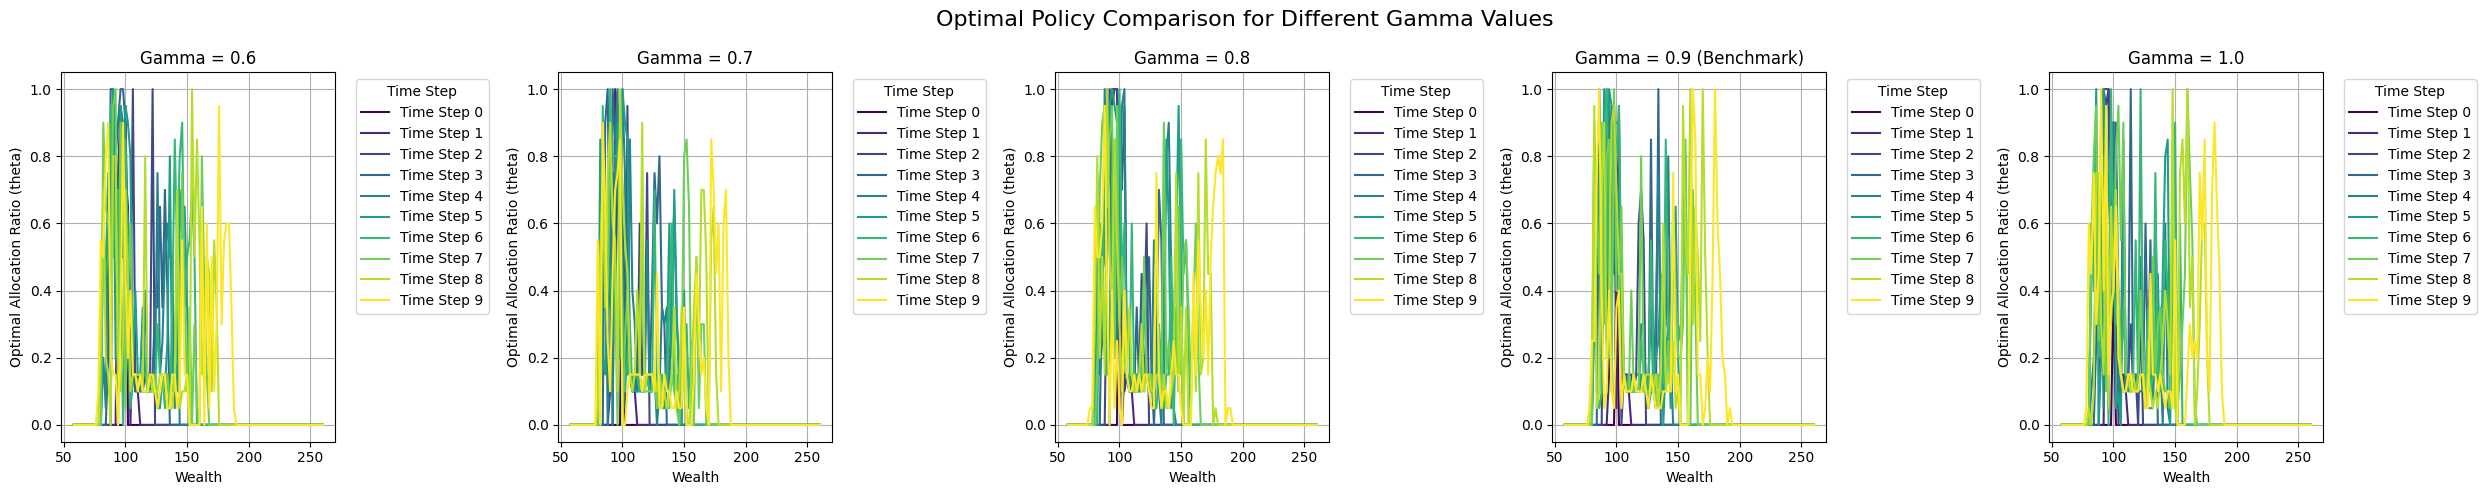

In [4]:
# Define gamma values to compare
gamma_values = [0.6, 0.7, 0.8, 0.9, 1.0]

# Create subplots
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
fig.suptitle("Optimal Policy Comparison for Different Gamma Values", fontsize=16)

# Run optimization for each gamma and plot results
for i, gamma in enumerate(gamma_values):
    print(f"Running with gamma = {gamma}")
    _, optimal_policy = run_portfolio_optimization(
        a, b, p, gamma, alpha, num_episodes, epsilon, wealth_bin_interval
    )
    
    # Plot for all time steps (T) in the current subplot
    T = optimal_policy.shape[1]
    colors = plt.cm.viridis(np.linspace(0, 1, T))
    for t in range(T):
        axes[i].plot(wealth_values, optimal_policy[:, t], label=f"Time Step {t}", color=colors[t])
    
    # Set subplot title and labels
    if gamma == 0.9:
        axes[i].set_title(f"Gamma = {gamma} (Benchmark)", fontsize=12)
    else:
        axes[i].set_title(f"Gamma = {gamma}", fontsize=12)
    axes[i].set_xlabel("Wealth")
    axes[i].set_ylabel("Optimal Allocation Ratio (theta)")
    axes[i].grid(True)
    axes[i].legend(title="Time Step", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Running with Benchmark: a=0.1, b=-0.05, p=0.6
Running with High Risk High Return: a=0.15, b=-0.1, p=0.5
Running with Low Risk Low Return: a=0.08, b=-0.02, p=0.7
Running with Medium Risk Medium Return: a=0.12, b=-0.06, p=0.6
Running with Extreme High Risk: a=0.2, b=-0.15, p=0.4
Running with Extreme Low Risk: a=0.05, b=-0.01, p=0.8


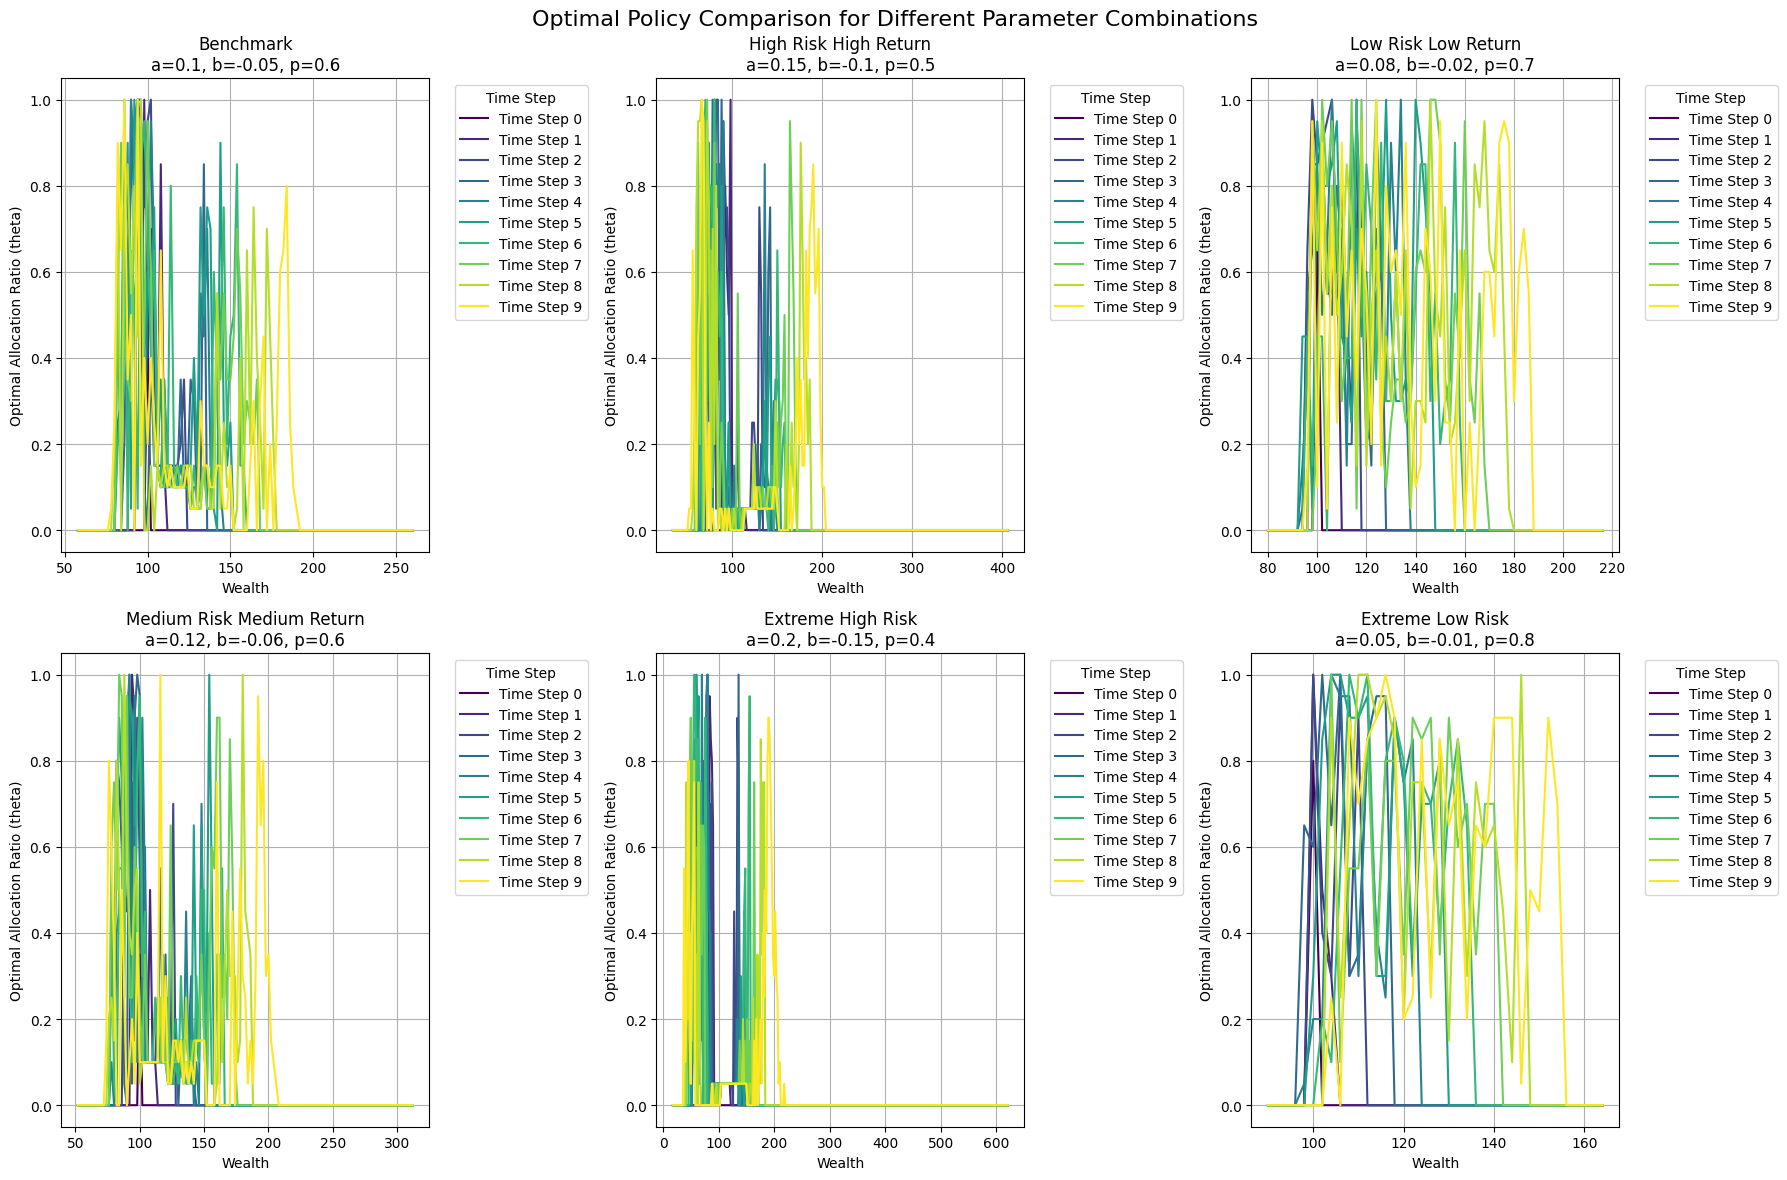

In [5]:
# Define parameter combinations
param_combinations = [
    {"a": 0.1, "b": -0.05, "p": 0.6, "label": "Benchmark"},
    {"a": 0.15, "b": -0.1, "p": 0.5, "label": "High Risk High Return"},
    {"a": 0.08, "b": -0.02, "p": 0.7, "label": "Low Risk Low Return"},
    {"a": 0.12, "b": -0.06, "p": 0.6, "label": "Medium Risk Medium Return"},
    {"a": 0.2, "b": -0.15, "p": 0.4, "label": "Extreme High Risk"},
    {"a": 0.05, "b": -0.01, "p": 0.8, "label": "Extreme Low Risk"},
]

# Create subplots: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Optimal Policy Comparison for Different Parameter Combinations", fontsize=16)

# Run optimization for each parameter combination and plot results
for i, params in enumerate(param_combinations):
    a, b, p, label = params["a"], params["b"], params["p"], params["label"]
    print(f"Running with {label}: a={a}, b={b}, p={p}")
    
    # Run optimization
    wealth_values, optimal_policy = run_portfolio_optimization(
        a, b, p, gamma, alpha, num_episodes, epsilon, wealth_bin_interval
    )
    
    # Determine subplot position
    row, col = i // 3, i % 3
    ax = axes[row, col]
    
    # Plot for all time steps (T)
    T = optimal_policy.shape[1]
    colors = plt.cm.viridis(np.linspace(0, 1, T))
    for t in range(T):
        ax.plot(wealth_values, optimal_policy[:, t], label=f"Time Step {t}", color=colors[t])
    
    # Set subplot title and labels
    if label == "Benchmark":
        ax.set_title(f"{label}\na={a}, b={b}, p={p}", fontsize=12)
    else:
        ax.set_title(f"{label}\na={a}, b={b}, p={p}", fontsize=12)
    ax.set_xlabel("Wealth")
    ax.set_ylabel("Optimal Allocation Ratio (theta)")
    ax.grid(True)
    ax.legend(title="Time Step", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Running with Baseline: alpha=0.1, num_episodes=100000
Running with High Alpha, Low Episodes: alpha=0.5, num_episodes=50000
Running with Low Alpha, High Episodes: alpha=0.01, num_episodes=200000
Running with Medium Alpha, High Episodes: alpha=0.2, num_episodes=150000
Running with High Alpha, Medium Episodes: alpha=0.3, num_episodes=100000
Running with Low Alpha, Low Episodes: alpha=0.05, num_episodes=50000


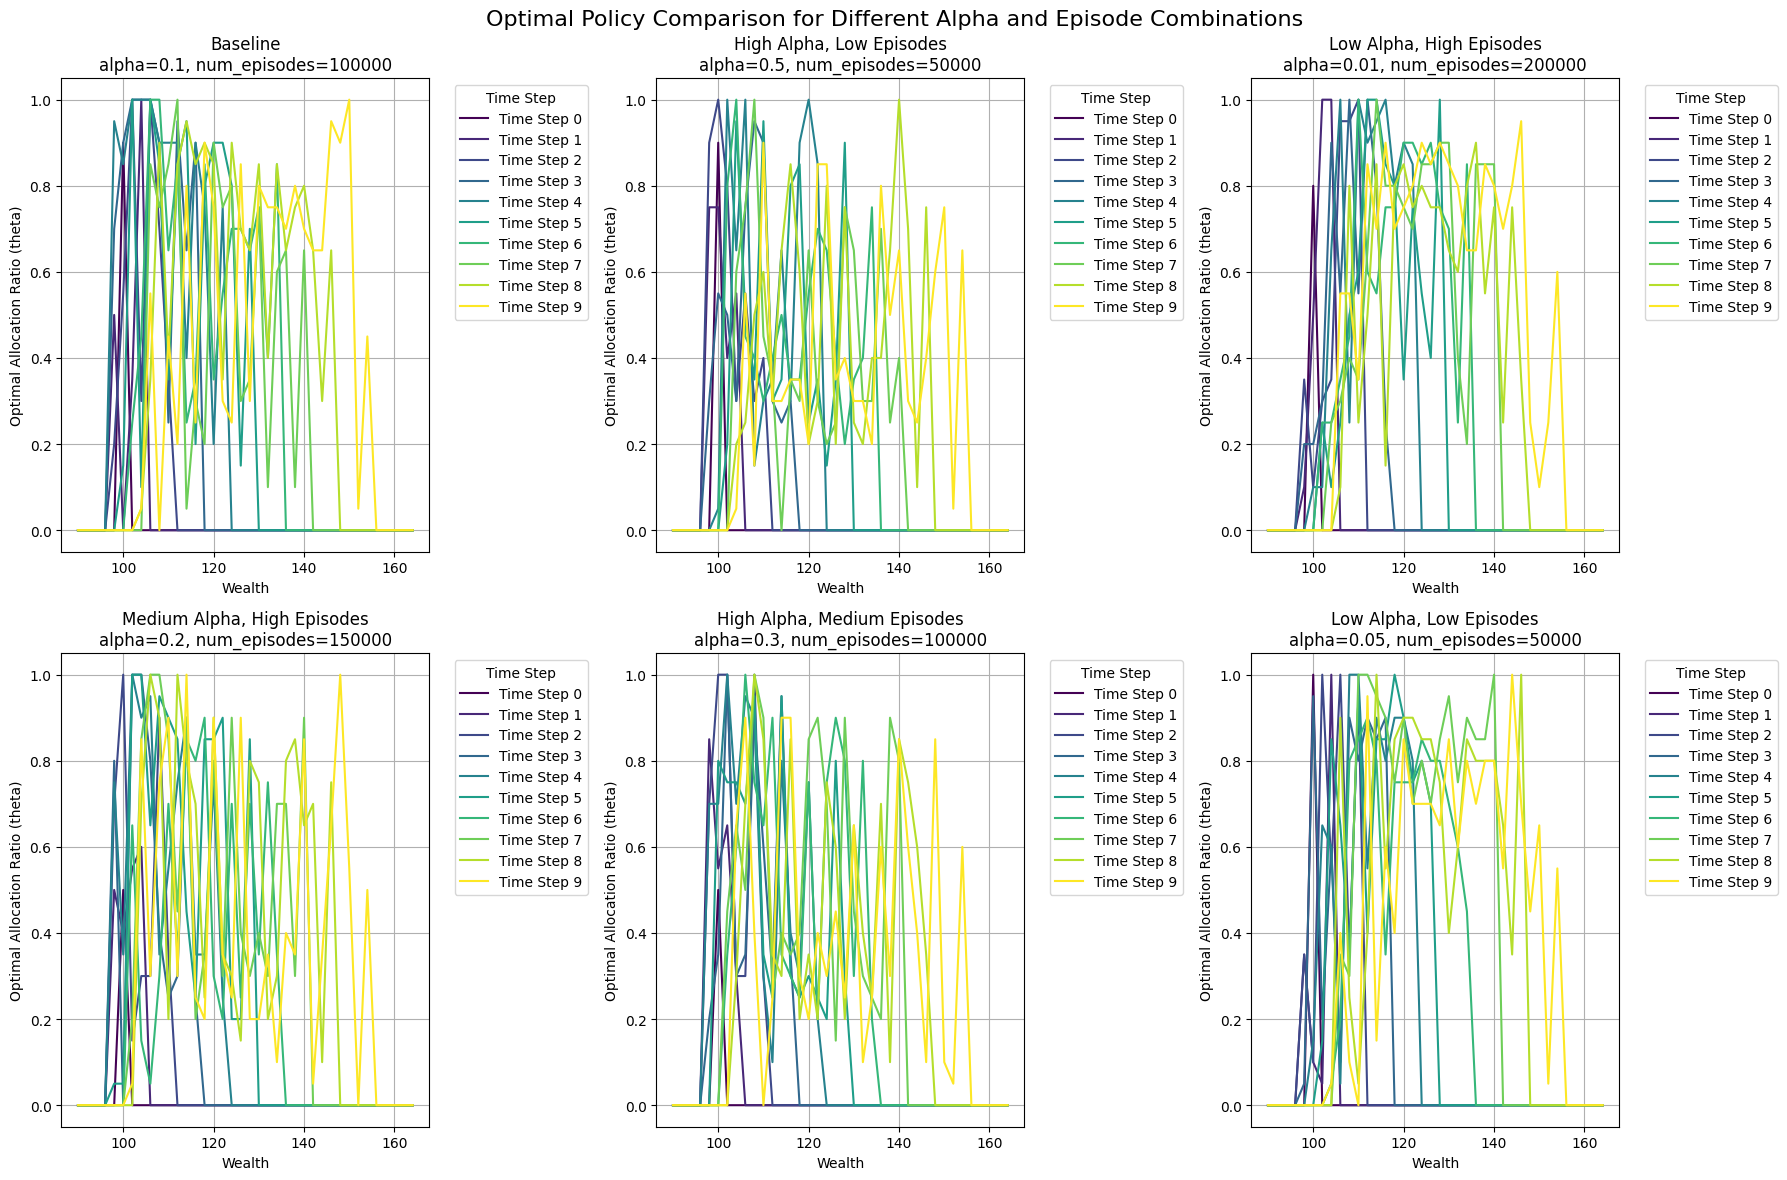

In [6]:
# Define parameter combinations for alpha and num_episodes
alpha_episode_combinations = [
    {"alpha": 0.1, "num_episodes": 100000, "label": "Baseline"},
    {"alpha": 0.5, "num_episodes": 50000, "label": "High Alpha, Low Episodes"},
    {"alpha": 0.01, "num_episodes": 200000, "label": "Low Alpha, High Episodes"},
    {"alpha": 0.2, "num_episodes": 150000, "label": "Medium Alpha, High Episodes"},
    {"alpha": 0.3, "num_episodes": 100000, "label": "High Alpha, Medium Episodes"},
    {"alpha": 0.05, "num_episodes": 50000, "label": "Low Alpha, Low Episodes"},
]

# Create subplots: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Optimal Policy Comparison for Different Alpha and Episode Combinations", fontsize=16)

# Run optimization for each parameter combination and plot results
for i, params in enumerate(alpha_episode_combinations):
    alpha, num_episodes, label = params["alpha"], params["num_episodes"], params["label"]
    print(f"Running with {label}: alpha={alpha}, num_episodes={num_episodes}")
    
    # Run optimization
    wealth_values, optimal_policy = run_portfolio_optimization(
        a, b, p, gamma, alpha, num_episodes, epsilon, wealth_bin_interval
    )
    
    # Determine subplot position
    row, col = i // 3, i % 3
    ax = axes[row, col]
    
    # Plot for all time steps (T)
    T = optimal_policy.shape[1]
    colors = plt.cm.viridis(np.linspace(0, 1, T))
    for t in range(T):
        ax.plot(wealth_values, optimal_policy[:, t], label=f"Time Step {t}", color=colors[t])
    
    # Set subplot title and labels
    if label == "Baseline":
        ax.set_title(f"{label}\nalpha={alpha}, num_episodes={num_episodes}", fontsize=12)
    else:
        ax.set_title(f"{label}\nalpha={alpha}, num_episodes={num_episodes}", fontsize=12)
    ax.set_xlabel("Wealth")
    ax.set_ylabel("Optimal Allocation Ratio (theta)")
    ax.grid(True)
    ax.legend(title="Time Step", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

Running with Fixed Epsilon (0.1)
Running with Fixed Epsilon (0.3)
Running with Fixed Epsilon (0.5)
Running with Linear Decay (1.0 -> 0.01)
Running with Exponential Decay (1.0 -> 0.01)
Running with Dynamic Adjustment


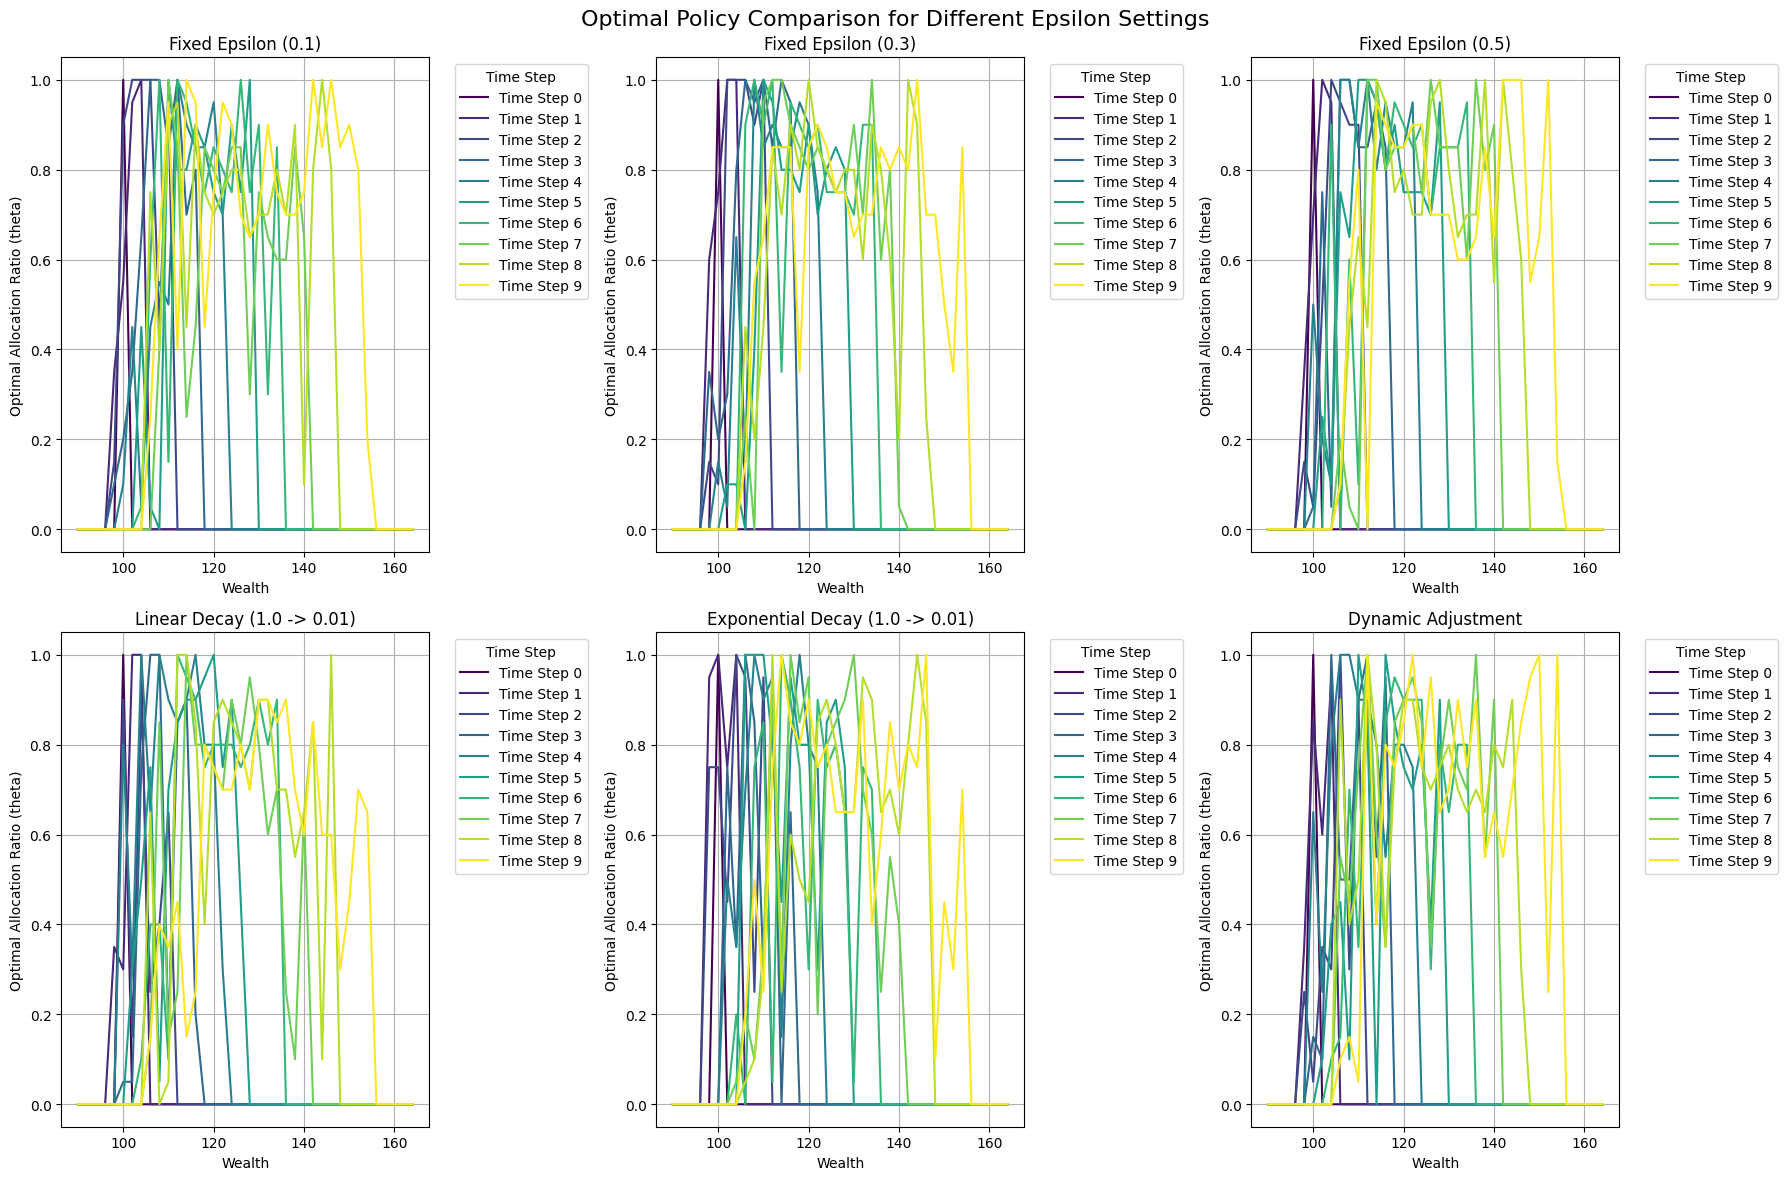

In [8]:
# Define epsilon combinations
epsilon_combinations = [
    {"epsilon": 0.1, "label": "Fixed Epsilon (0.1)"},
    {"epsilon": 0.3, "label": "Fixed Epsilon (0.3)"},
    {"epsilon": 0.5, "label": "Fixed Epsilon (0.5)"},
    {"epsilon": "linear_decay", "label": "Linear Decay (1.0 -> 0.01)"},
    {"epsilon": "exponential_decay", "label": "Exponential Decay (1.0 -> 0.01)"},
    {"epsilon": "dynamic", "label": "Dynamic Adjustment"},
]

# Function to get epsilon value based on the combination and episode
def get_epsilon(epsilon_setting, episode, num_episodes):
    if epsilon_setting == "linear_decay":
        # Linear decay from 1.0 to 0.01
        return max(0.01, 1.0 - (1.0 - 0.01) * (episode / num_episodes))
    elif epsilon_setting == "exponential_decay":
        # Exponential decay from 1.0 to 0.01
        return max(0.01, 1.0 * (0.01 / 1.0) ** (episode / num_episodes))
    elif epsilon_setting == "dynamic":
        # Dynamic adjustment based on performance (placeholder logic)
        return max(0.01, 1.0 - (episode / num_episodes))  # Example logic
    else:
        # Fixed epsilon
        return epsilon_setting

# Create subplots: 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle("Optimal Policy Comparison for Different Epsilon Settings", fontsize=16)

# Run optimization for each epsilon setting and plot results
for i, params in enumerate(epsilon_combinations):
    epsilon_setting, label = params["epsilon"], params["label"]
    print(f"Running with {label}")
    
    # Initialize Q-table
    Q = np.zeros((len(wealth_values), T, len(theta_bins)))
    
    # TD Learning loop
    for episode in range(num_episodes):
        W = W0
        _, W = map_to_wealth_bin(W)  # Map initial wealth
        epsilon = get_epsilon(epsilon_setting, episode, num_episodes)  # Get epsilon value
        for t in range(T):
            W_idx, _ = map_to_wealth_bin(W)
            if np.random.rand() < epsilon:
                theta_idx = np.random.choice(len(theta_bins))  # Explore
            else:
                theta_idx = np.argmax(Q[W_idx, t])  # Exploit
            theta = theta_bins[theta_idx]
            
            W_next, reward = step(W, t, theta)
            W_next_idx, _ = map_to_wealth_bin(W_next)
            
            if t == T - 1:  # t=T-1
                reward = -np.exp(-a * W_next) / a
                Q_target = reward
            else:
                reward = 0
                Q_target = reward + gamma * np.max(Q[W_next_idx, t + 1])  # Include discounted future reward
            
            # if t == T - 1:
            #     Q_target = reward
            # else:
            #     Q_target = reward + gamma * np.max(Q[W_next_idx, t + 1])
            
            Q[W_idx, t, theta_idx] += alpha * (Q_target - Q[W_idx, t, theta_idx])
            W = W_next
    
    # Compute optimal policy
    optimal_policy = np.zeros((len(wealth_values), T))
    for W_idx in range(len(wealth_values)):
        for t in range(T):
            optimal_policy[W_idx, t] = theta_bins[np.argmax(Q[W_idx, t])]
    
    # Determine subplot position
    row, col = i // 3, i % 3
    ax = axes[row, col]
    
    # Plot for all time steps (T)
    T = optimal_policy.shape[1]
    colors = plt.cm.viridis(np.linspace(0, 1, T))
    for t in range(T):
        ax.plot(wealth_values, optimal_policy[:, t], label=f"Time Step {t}", color=colors[t])
    
    # Set subplot title and labels
    ax.set_title(label, fontsize=12)
    ax.set_xlabel("Wealth")
    ax.set_ylabel("Optimal Allocation Ratio (theta)")
    ax.grid(True)
    ax.legend(title="Time Step", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()